# Car insurance - Modeling pure premium 

In [1]:
import os
import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from xgboost import XGBRegressor



In [2]:
RANDOM_SEED = 42


### Data Exploration

In [3]:
data_dir = './data'

#   Part 1
data_freq = arff.load(os.path.join(data_dir, 'freMTPL2freq.arff'))

df_freq = pd.DataFrame(data_freq , columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"] )


display(df_freq.head())

print("Dataset size: ", len(df_freq))

print("IDpol has only unique values? ", (df_freq['IDpol'].nunique() == len(df_freq['IDpol'])))

display('Description of dataset: ', df_freq.describe(include='all'))



,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


Dataset size:  678013
IDpol has only unique values?  True


'Description of dataset: '

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
count,6.780130e+05,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22
top,NaN,NaN,NaN,'C',NaN,NaN,NaN,NaN,'B12',Regular,NaN,'R24'
freq,NaN,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601
mean,2.621857e+06,0.053247,0.528750,NaN,6.454631,7.044265,45.499122,59.761502,NaN,NaN,1792.422405,NaN
std,1.641783e+06,0.240117,0.364442,NaN,2.050906,5.666232,14.137444,15.636658,NaN,NaN,3958.646564,NaN
min,1.000000e+00,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN
25%,1.157951e+06,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN
50%,2.272152e+06,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN
75%,4.046274e+06,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN


In [4]:

#   Part 2

data_sev = arff.load(os.path.join(data_dir, 'freMTPL2sev.arff'))

df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])


display(df_sev.head())

print("Dataset size: ", len(df_sev))

print("Percentage of IDpol-contracts with only one ClaimAmount: ", 
      round(df_sev['IDpol'].nunique()/len(df_sev['IDpol']), 4))

display('Description of dataset: ', df_sev.describe(include='all'))


print('Data types in ClaimAmount column:', df_sev["ClaimAmount"].apply(type).unique(), '\n')



,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


Dataset size:  26639
Percentage of IDpol-contracts with only one ClaimAmount:  0.9366


'Description of dataset: '

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
max,6.113971e+06,4.075401e+06


Data types in ClaimAmount column: [<class 'float'>] 



### Join data from both data tables

In [5]:
#   Sum up ClaimAmount for each distinct IDpol (contract)

df_sev_sum = df_sev.groupby(['IDpol'])[['ClaimAmount']].agg('sum').reset_index()

display(df_sev_sum)

,IDpol,ClaimAmount
0,139.0,303.00
1,190.0,1981.84
2,414.0,1456.55
3,424.0,10834.00
4,463.0,3986.67
...,...,...
24945,6113521.0,1324.40
24946,6113793.0,1769.88
24947,6113817.0,1288.28
24948,6113834.0,12230.40


In [6]:
#   Left join features table with ClaimAmount-table (containing unique IDpol)

df_combined = df_freq.merge(df_sev_sum, on="IDpol", how='left')

#   Fill None values of ClaimAmount with 0.0
df_combined["ClaimAmount"] = df_combined["ClaimAmount"].fillna(value=0.0)


#     Correct ClaimNb to 0 if ClaimAmount is 0 (assuming that ClaimAmount is ground truth)
df_combined["ClaimNb"] = np.where(df_combined["ClaimAmount"] == 0, 0, df_combined["ClaimNb"])


#   Construct the Pure Premium column (ClaimAmount / Exposure)
df_combined["ClaimAmount_Per_Year"] = df_combined["ClaimAmount"] / df_combined["Exposure"]

display(df_combined)

# TODO: drop 5% outliers w.r.t. certain columns?


print("Percentage of Policy Holders with no claims: ", 
      round(len(df_combined[df_combined["ClaimNb"] == 0.0]) / len(df_combined), 4))


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmount_Per_Year
0,1.0,0.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
1,3.0,0.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
2,5.0,0.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',0.0,0.0
3,10.0,0.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
4,11.0,0.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',0.0,0.0
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',0.0,0.0
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',0.0,0.0
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',0.0,0.0


Percentage of Policy Holders with no claims:  0.9632


In [7]:
#   Check if num of IDpols is correct

if len(df_combined) != len(df_freq):
    raise Exception("Wrong dimensions for df_combined")

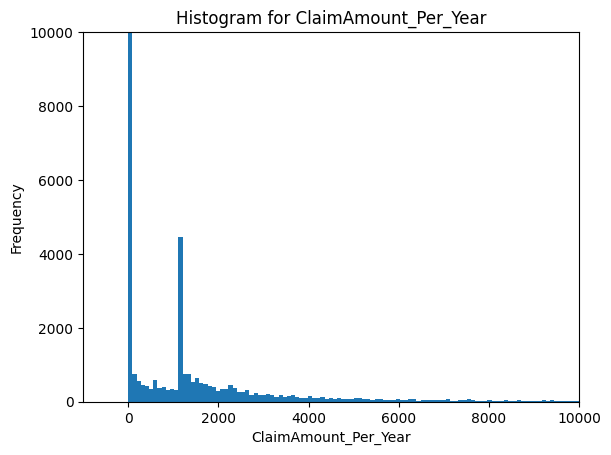

In [8]:
#   Histogram for ClaimAmount_Per_Year

plt.hist(df_combined["ClaimAmount_Per_Year"], bins=200000, density=False)

plt.title('Histogram for ClaimAmount_Per_Year')
plt.xlabel('ClaimAmount_Per_Year')
plt.xlim(-1e3, 1e4) 
plt.ylim(0, 1e4) 
plt.ylabel('Frequency')
plt.show()

In [9]:
#   (Optional) Randomly drop certain amount of No-Claim cases (vast majority)
#   so that balance between Claim <-> No-Claim cases is better

"""

no_claim_cases_indices = df_combined[df_combined["ClaimAmount"] == 0.0].index

#   Important to put here (cell re-run...)
np.random.seed(RANDOM_SEED)

indices_for_dropping = np.random.choice(no_claim_cases_indices, 
                                        size=200000,  # 625000
                                        replace=False)

df_combined.drop(index=indices_for_dropping, inplace=True)

"""

'\n\nno_claim_cases_indices = df_combined[df_combined["ClaimAmount"] == 0.0].index\n\n#   Important to put here (cell re-run...)\nnp.random.seed(RANDOM_SEED)\n\nindices_for_dropping = np.random.choice(no_claim_cases_indices, \n                                        size=200000,  # 625000\n                                        replace=False)\n\ndf_combined.drop(index=indices_for_dropping, inplace=True)\n\n'

### Create features (Encoding and Scaling) and labels

In [10]:

X = df_combined.drop(
    columns=["IDpol", "ClaimNb", "Exposure", "ClaimAmount", "ClaimAmount_Per_Year"]).reset_index(drop=True)

print("Original Features:")
display(X)


#   Binning, Encoding and Scaling of certain columns

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=RANDOM_SEED),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ]
)

X_encoded = column_trans.fit_transform(X).toarray()


transformed_columns = []

for name, transformer, columns in column_trans.transformers_:
    if isinstance(transformer, KBinsDiscretizer):
        #   KBinsDiscretizer replaces 2 cols with 20 cols
        transformed_columns.extend(transformer.get_feature_names_out(input_features=columns))
    elif isinstance(transformer, OneHotEncoder):
        #   OneHotEncoder replaces 5 cols with 53 cols
        transformed_columns.extend(transformer.get_feature_names_out(input_features=columns))
    else:
        #   passthrough and log_scale_transformer replace their column
        transformed_columns.extend(columns)

print(f'Col names; length {len(transformed_columns)} : ', transformed_columns)

print(f"Encoded Features; type {type(X_encoded)}, shape {X_encoded.shape} : ")
display(X_encoded)




#############################################################


#   Potential target cols - here ClaimAmount_Per_Year will be used

Y = df_combined[["ClaimNb", "Exposure", "ClaimAmount", "ClaimAmount_Per_Year"]]

print(Y)


Original Features:


,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
...,...,...,...,...,...,...,...,...,...
678008,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93'
678009,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11'
678010,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82'
678011,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26'


Col names; length 75 :  ['VehAge_0.0', 'VehAge_1.0', 'VehAge_2.0', 'VehAge_3.0', 'VehAge_4.0', 'VehAge_5.0', 'VehAge_6.0', 'VehAge_7.0', 'VehAge_8.0', 'VehAge_9.0', 'DrivAge_0.0', 'DrivAge_1.0', 'DrivAge_2.0', 'DrivAge_3.0', 'DrivAge_4.0', 'DrivAge_5.0', 'DrivAge_6.0', 'DrivAge_7.0', 'DrivAge_8.0', 'DrivAge_9.0', "VehBrand_'B1'", "VehBrand_'B10'", "VehBrand_'B11'", "VehBrand_'B12'", "VehBrand_'B13'", "VehBrand_'B14'", "VehBrand_'B2'", "VehBrand_'B3'", "VehBrand_'B4'", "VehBrand_'B5'", "VehBrand_'B6'", 'VehPower_4.0', 'VehPower_5.0', 'VehPower_6.0', 'VehPower_7.0', 'VehPower_8.0', 'VehPower_9.0', 'VehPower_10.0', 'VehPower_11.0', 'VehPower_12.0', 'VehPower_13.0', 'VehPower_14.0', 'VehPower_15.0', 'VehGas_Diesel', 'VehGas_Regular', "Region_'R11'", "Region_'R21'", "Region_'R22'", "Region_'R23'", "Region_'R24'", "Region_'R25'", "Region_'R26'", "Region_'R31'", "Region_'R41'", "Region_'R42'", "Region_'R43'", "Region_'R52'", "Region_'R53'", "Region_'R54'", "Region_'R72'", "Region_'R73'", "Reg

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
        50.        ,  0.60005456],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        50.        ,  0.60005456],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        50.        , -1.06540391],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        50.        ,  0.64470317],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        50.        , -0.76339517],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        54.        , -0.96628176]])

        ClaimNb  Exposure  ClaimAmount  ClaimAmount_Per_Year
0           0.0   0.10000          0.0                   0.0
1           0.0   0.77000          0.0                   0.0
2           0.0   0.75000          0.0                   0.0
3           0.0   0.09000          0.0                   0.0
4           0.0   0.84000          0.0                   0.0
...         ...       ...          ...                   ...
678008      0.0   0.00274          0.0                   0.0
678009      0.0   0.00274          0.0                   0.0
678010      0.0   0.00274          0.0                   0.0
678011      0.0   0.00274          0.0                   0.0
678012      0.0   0.00274          0.0                   0.0

[678013 rows x 4 columns]


### Splitting data

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED
                                                    )

print("Shape of X_train: ", X_train.shape, " Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape, " Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (542410, 75)  Shape of Y_train:  (542410, 4)
Shape of X_test:  (135603, 75)  Shape of Y_test:  (135603, 4)


### Create and fit model

In [12]:
# Using Gradient boosted decision trees: XGBoost -> optimized for large datasets

PARAM_SEARCH = False

default_params = {
    "objective": "reg:tweedie",
    "tweedie_variance_power": 1.05,  #   Closer to Poisson -> large number of 0.0
    "booster": 'gbtree',
    'n_estimators': 5000,
    "learning_rate": 0.01,
    "max_depth": 20,
    "subsample": 1,
    "colsample_bytree": 1,
    "random_state": RANDOM_SEED,    
}

param_grid = {
    'n_estimators': [100, 300, 500, 700, 900],
    "learning_rate": [0.05, 0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}


if PARAM_SEARCH:
    estim = XGBRegressor(objective="reg:tweedie", 
                         random_state=RANDOM_SEED)


    #   Using 5-fold cross-validation
    random_search = RandomizedSearchCV(estimator=estim, 
                                    param_distributions=param_grid, 
                                    n_iter=10, 
                                    cv=5, 
                                    random_state=RANDOM_SEED)
    random_search.fit(X=X_train, 
                      y=Y_train["ClaimAmount_Per_Year"], 
                      sample_weight=Y_train["Exposure"])
    
    model = random_search.best_estimator_

    model_params = random_search.best_params_
else:
    model = XGBRegressor(**default_params)

    model.fit(X=X_train, 
              y=Y_train["ClaimAmount_Per_Year"], 
              sample_weight=Y_train["Exposure"],
              )
    
    model_params = default_params


print("Hyperparameters: ", model_params)


Hyperparameters:  {'objective': 'reg:tweedie', 'tweedie_variance_power': 1.05, 'booster': 'gbtree', 'n_estimators': 5000, 'learning_rate': 0.01, 'max_depth': 20, 'subsample': 1, 'colsample_bytree': 1, 'random_state': 42}


### Evaluation of model

Performance on train data 

 Mean Absolute Error (train): 148.95
 Mean Absolute Percentage Error (train): 2.2774134460783936e+17


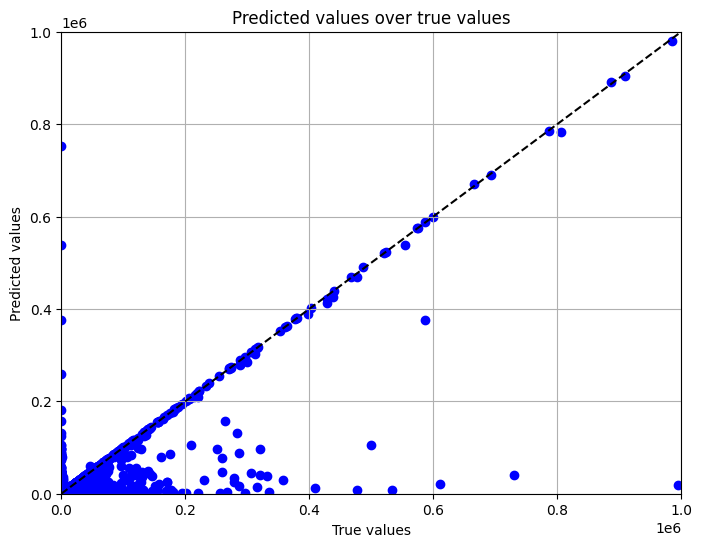

In [13]:
#   Performance on train data

train_preds = model.predict(X_train)
train_trues = Y_train["ClaimAmount_Per_Year"]

mae_train = mean_absolute_error(train_trues, train_preds)
mape_train = mean_absolute_percentage_error(train_trues, train_preds)

print("Performance on train data \n")
print(" Mean Absolute Error (train):", round(mae_train, 2))
print(" Mean Absolute Percentage Error (train):", round(mape_train, 4))


plt.figure(figsize=(8, 6))
plt.scatter(train_trues, train_preds, color='blue')
plt.plot([train_trues.min(), train_trues.max()], 
         [train_trues.min(), train_trues.max()], 
         color='black', 
         linestyle='--')
plt.title('Predicted values over true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(0, 1e6)
plt.ylim(0, 1e6)
plt.grid(True)
plt.show()


Performance on test data 

Mean Absolute Error (test): 550.26
Mean Absolute Percentage Error (test): 5.858982519127164e+17


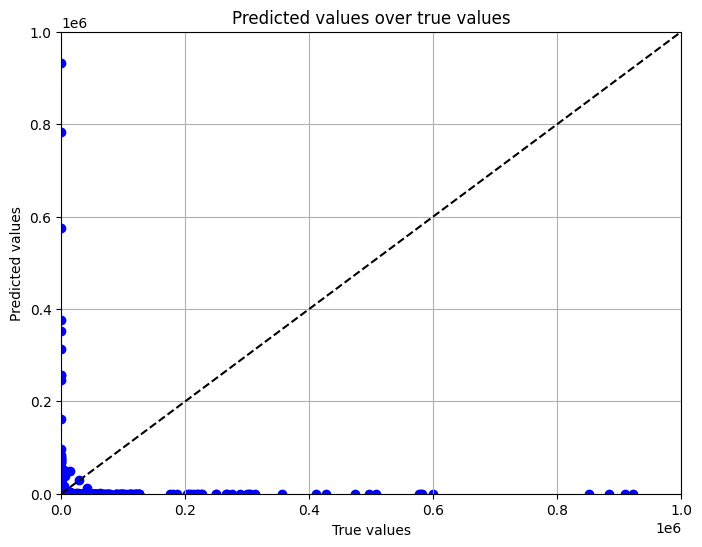

In [14]:
#   Performance test data

test_preds = model.predict(X_test)
test_trues = Y_test["ClaimAmount_Per_Year"]

mae_test = mean_absolute_error(test_trues, test_preds)
mape_test = mean_absolute_percentage_error(test_trues, test_preds)

print("Performance on test data \n")
print("Mean Absolute Error (test):", round(mae_test, 2))
print("Mean Absolute Percentage Error (test):", round(mape_test, 4))


plt.figure(figsize=(8, 6))
plt.scatter(test_trues, test_preds, color='blue')
plt.plot([test_trues.min(), test_trues.max()], 
         [test_trues.min(), test_trues.max()], 
         color='black', 
         linestyle='--')
plt.title('Predicted values over true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(0, 1e6)
plt.ylim(0, 1e6)
plt.grid(True)
plt.show()


### Feature Importance

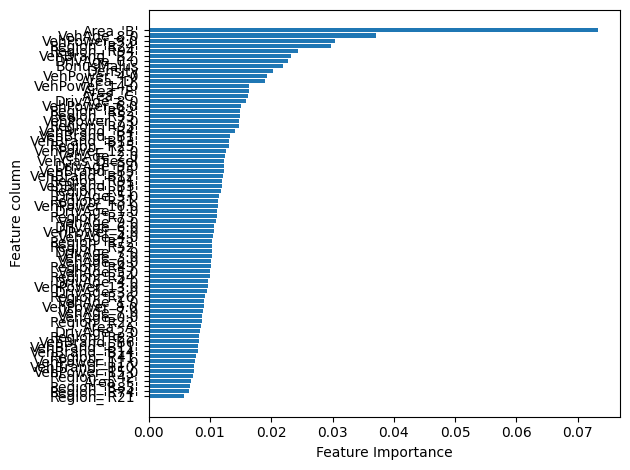

In [15]:
#   Get most important features and their importance

feature_importances_dict = dict(zip(transformed_columns, model.feature_importances_))

#   Sort by value
feature_importances_sorted= sorted(feature_importances_dict.items(), key=lambda item: item[1])

#   Drop zero importance columns
feature_importances_dict = {k: v for k, v in feature_importances_sorted if v != 0}


#   Plot feature importances

fig, ax = plt.subplots()

plt.barh(list(feature_importances_dict.keys()), list(feature_importances_dict.values()))

ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature column")
fig.tight_layout()

plt.show()

### Towards model improvement

- Drop outliers in dataset
- Train model on Principal component analysis (PCA) transformed training data (-> fit PCA model)


